# Clustering de documents

## Imports

In [54]:
# Imports essentiels
import os
import string
import re
import collections
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.snowball import FrenchStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances

# Downloads nécessaires
nltk.download('punkt')
nltk.download('stopwords')

# Configuration corpus
data_path = "../../data/txt_tp4/"


[nltk_data] Downloading package punkt to /Users/ilaria/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ilaria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
# tous les fichiers .txt
files = sorted([f for f in os.listdir(data_path) if f.endswith(".txt")])

# on charge les textes
texts = [open(os.path.join(data_path, f), "r", encoding="utf-8").read()
         for f in files]

print("Nombre de documents chargés :", len(texts))


Nombre de documents chargés : 999


In [59]:
# Filtrer les articles contenant “sorcière” + (femm ou fémin)**

def matches_query(text):
    text_lower = text.lower()
    cond1 = "sorcière" in text_lower or "sorciere" in text_lower
    cond2 = bool(re.search(r"\bfemm\w*|\bfémin\w*", text_lower))
    return cond1 and cond2

filtered_files = []
filtered_texts = []

for f, t in zip(files, texts):
    if matches_query(t):
        filtered_files.append(f)
        filtered_texts.append(t)

print("Articles correspondant à la requête :", len(filtered_texts))


Articles correspondant à la requête : 993


In [60]:
def is_noise(text):
    # trop de chiffres → petites annonces
    if len(re.findall(r"\d{3,}", text)) > 30:
        return True
    # trop d'heures → programmes radio/tv
    if len(re.findall(r"\b\d{2}h\d{2}\b|\b\d{4}\b", text)) > 20:
        return True
    return False

clean_files = []
clean_texts = []

for f, t in zip(filtered_files, filtered_texts):
    if not is_noise(t):
        clean_files.append(f)
        clean_texts.append(t)

print("Documents après nettoyage :", len(clean_texts))


Documents après nettoyage : 320


In [61]:
stemmer = FrenchStemmer()

def preprocessing(text):
    text = text.lower()
    text = re.sub(r"\d+", " ", text)               # supprimer nombres
    text = re.sub(r"[^\w\s]", " ", text)          # supprimer ponctuation
    text = re.sub(r"\s+", " ", text)              # espace unique
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if len(t) > 2]    # supprimer tokens courts
    tokens = [stemmer.stem(t) for t in tokens]    # racinisation
    return tokens

# Test rapide
print(preprocessing(clean_texts[0])[:20])


['samed', 'janvi', 'som', 'conseil', 'guerr', 'bruxel', 'proces', 'von', 'falkenhausen', 'audienc', 'vendred', 'rolin', 'poursuiv', 'répliqu', 'trait', 'question', 'juiv', 'soulign', 'le', 'dizain']


## TF-IDF sur les textes filtrés

In [62]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words("french") + ["comme","ainsi","cela","cette","etc"],
    min_df=3,
    max_df=0.4
)

tfidf_vectors = vectorizer.fit_transform(clean_texts)
print("Shape TF-IDF :", tfidf_vectors.shape)


/Users/ilaria/Desktop/STIC/traitement_auto_corpus/tac/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/ilaria/Desktop/STIC/traitement_auto_corpus/tac/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ains', 'aur', 'aurion', 'auron', 'avi', 'avion', 'avon', 'ayon', 'cel', 'cet', 'comm', 'dan', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'mêm', 'notr', 'ser', 'serion', 'seron', 'soi', 'somm', 'soyon', 'votr', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Shape TF-IDF : (320, 16384)


### Clustering KMeans

### Regrouper les fichiers par cluster

In [63]:
N_CLUSTERS = 4
km_model = KMeans(n_clusters=N_CLUSTERS, random_state=42)
clusters = km_model.fit_predict(tfidf_vectors)

# Regrouper fichiers par cluster
clustering = collections.defaultdict(list)
for idx, label in enumerate(clusters):
    clustering[label].append(clean_files[idx])

pprint(dict(clustering))


{np.int32(0): ['KB_JB838_1951-01-20_01-00005.txt',
               'KB_JB838_1951-05-11_01-00002.txt',
               'KB_JB838_1951-06-09_01-00001.txt',
               'KB_JB838_1952-07-26_01-00005.txt',
               'KB_JB838_1952-10-09_01-00002.txt',
               'KB_JB838_1953-03-29_01-00006.txt',
               'KB_JB838_1953-11-12_01-00004.txt',
               'KB_JB838_1954-03-05_01-00005.txt',
               'KB_JB838_1954-03-15_01-00010.txt',
               'KB_JB838_1954-03-27_01-00002.txt',
               'KB_JB838_1954-06-25_01-00002.txt',
               'KB_JB838_1954-11-17_01-00005.txt',
               'KB_JB838_1954-11-24_01-00003.txt',
               'KB_JB838_1955-03-26_01-00002.txt',
               'KB_JB838_1955-06-15_01-00005.txt',
               'KB_JB838_1955-09-09_01-00002.txt',
               'KB_JB838_1955-10-12_01-00007.txt',
               'KB_JB838_1955-11-01_01-00005.txt',
               'KB_JB838_1955-12-21_01-00005.txt',
               'KB_JB838_1956-0

### Extraire les mots caractéristiques de chaque cluster

In [64]:
centers = km_model.cluster_centers_
terms = vectorizer.get_feature_names_out()

N_TOP = 20
cluster_keywords = {}

for i in range(N_CLUSTERS):
    top_idx = centers[i].argsort()[-N_TOP:][::-1]
    cluster_keywords[i] = [terms[j] for j in top_idx]

pprint(cluster_keywords)


{0: ['ministr',
     'président',
     'gouvern',
     'loi',
     'administr',
     'économ',
     'comit',
     'communal',
     'enseign',
     'juin',
     'équip',
     'exposit',
     'match',
     'traval',
     'défens',
     'commerc',
     'directeur',
     'étudi',
     'bat',
     'plant'],
 1: ['concert',
     'magazin',
     'aff',
     'symphon',
     'feuilleton',
     'theatr',
     'jazz',
     'disqu',
     'scolair',
     'luxembourg',
     'actual',
     'chain',
     'chaîn',
     'concerto',
     'jeux',
     'radio',
     'piano',
     'sant',
     'mozart',
     'emiss'],
 2: ['ena',
     'enf',
     'admis',
     'adm',
     'tech',
     'techn',
     'scop',
     'theatr',
     'relâch',
     'mol',
     'path',
     'technicolor',
     'rio',
     'coul',
     'cinémascop',
     'dim',
     'movy',
     'fernandel',
     'ecran',
     'vendom'],
 3: ['poet',
     'écrivain',
     'poes',
     'ouvrag',
     'edit',
     'rec',
     'cinéast',
     'romanci',

## Comprendre le cluster et leurs thematiques

### Barplots : visualisation quantitative des mots-clés

In [ ]:
def plot_cluster_keywords(cluster_keywords, cluster_id):
    words, scores = zip(*cluster_keywords[cluster_id])
    plt.figure(figsize=(10, 6))
    plt.barh(words[::-1], scores[::-1], color="steelblue")
    plt.title(f"Top mots–clés du cluster {cluster_id}")
    plt.xlabel("Poids TF-IDF (centre du cluster)")
    plt.show()

# Exemple : cluster 0
plot_cluster_keywords(cluster_keywords, 0)


ValueError: too many values to unpack (expected 2)

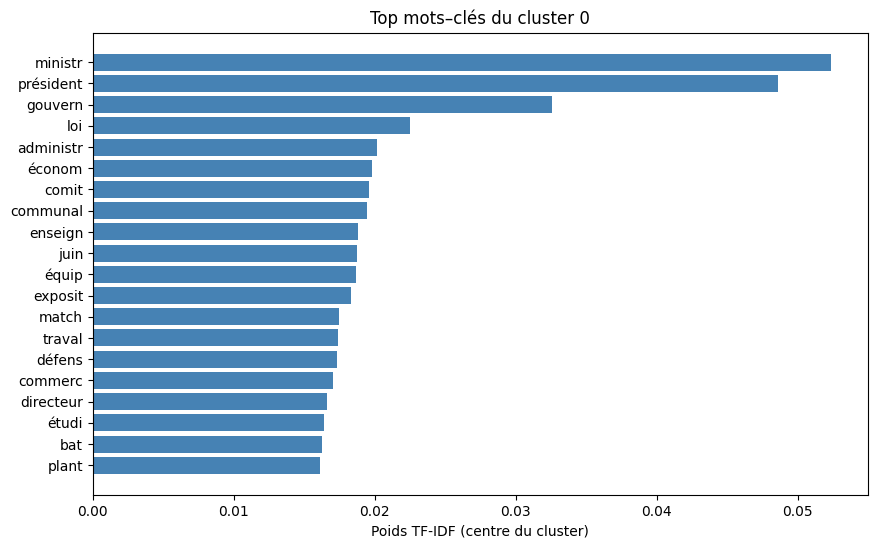

In [75]:
def plot_cluster_keywords(cluster_keywords, cluster_id):
    words, scores = zip(*cluster_keywords[cluster_id])
    plt.figure(figsize=(10, 6))
    plt.barh(words[::-1], scores[::-1], color="steelblue")
    plt.title(f"Top mots–clés du cluster {cluster_id}")
    plt.xlabel("Poids TF-IDF (centre du cluster)")
    plt.show()

# Exemple : cluster 0
plot_cluster_keywords(cluster_keywords, 0)


### Nouage de points 

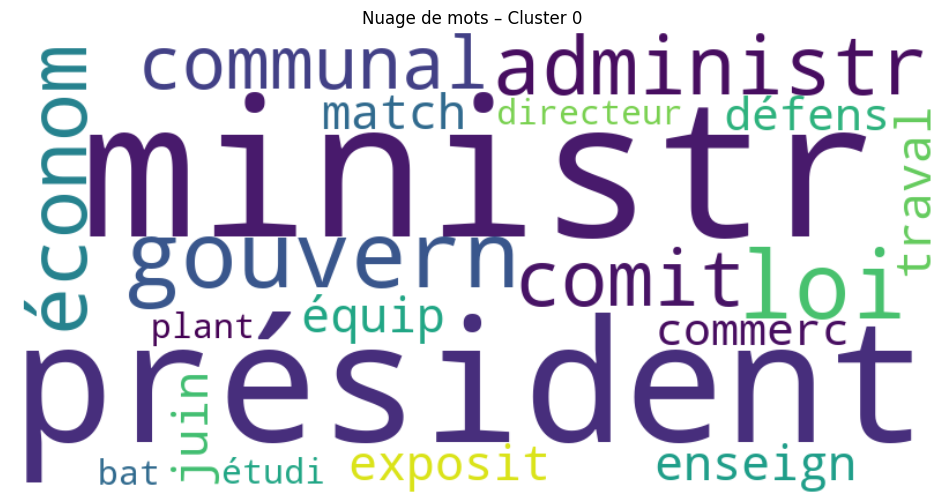

In [66]:
def plot_wordcloud(cluster_keywords, cluster_id):
    # fréquence simple = chaque mot compte pour 1
    freq = {word: 1 for word in cluster_keywords[cluster_id]}

    wc = WordCloud(width=800, height=400, background_color="white")
    wc = wc.generate_from_frequencies(freq)
    
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Nuage de mots – Cluster {cluster_id}")
    plt.show()

plot_wordcloud(cluster_keywords, 0)


### Résuler les thématiques via topic-embedding PCA

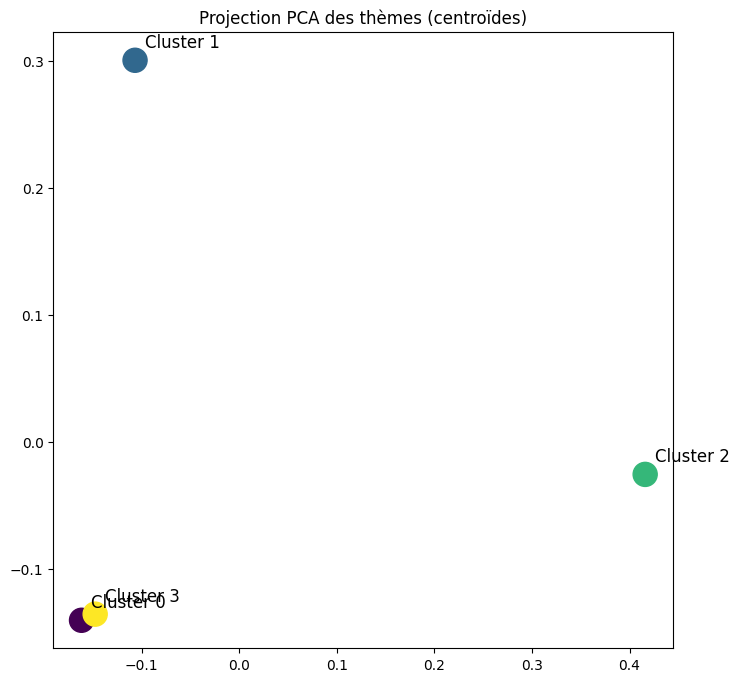

In [67]:
# Cette carte montre la position thématique globale de chaque cluster
ca = PCA(n_components=2)
cluster_points = pca.fit_transform(km_model.cluster_centers_)

plt.figure(figsize=(8,8))
plt.scatter(cluster_points[:,0], cluster_points[:,1], s=300, c=range(N_CLUSTERS))

for i, (x,y) in enumerate(cluster_points):
    plt.text(x+0.01, y+0.01, f"Cluster {i}", fontsize=12)

plt.title("Projection PCA des thèmes (centroïdes)")
plt.show()


### Explorer les mots les plus discriminants entre clusters

In [68]:
# gébérer des mots-clés avec scores
km_model = KMeans(n_clusters=N_CLUSTERS, random_state=42)
clusters = km_model.fit_predict(tfidf_vectors)


# extraction des mots clés avec scores

centers = km_model.cluster_centers_
terms = vectorizer.get_feature_names_out()

cluster_keywords = {}
N_TOP = 20

for i in range(N_CLUSTERS):
    idx = centers[i].argsort()[-N_TOP:][::-1]
    # Chaque cluster devient une liste de tuples (mot, score)
    cluster_keywords[i] = [(terms[j], centers[i][j]) for j in idx]

print("\nMots-clés par cluster (avec scores) :")
pprint(cluster_keywords)



Mots-clés par cluster (avec scores) :
{0: [('ministr', np.float64(0.052342539644754035)),
     ('président', np.float64(0.048604775873031913)),
     ('gouvern', np.float64(0.03254943536968274)),
     ('loi', np.float64(0.02251047242390223)),
     ('administr', np.float64(0.020162200577151686)),
     ('économ', np.float64(0.019787861909637296)),
     ('comit', np.float64(0.01957566363957638)),
     ('communal', np.float64(0.01944377703276499)),
     ('enseign', np.float64(0.018778099653278594)),
     ('juin', np.float64(0.01876396389143669)),
     ('équip', np.float64(0.018656982549456382)),
     ('exposit', np.float64(0.0183299380517986)),
     ('match', np.float64(0.017454566092689503)),
     ('traval', np.float64(0.017413116513303864)),
     ('défens', np.float64(0.0173243887775522)),
     ('commerc', np.float64(0.017013639210682663)),
     ('directeur', np.float64(0.016578047331973936)),
     ('étudi', np.float64(0.01636385554823118)),
     ('bat', np.float64(0.016216826287452704))

In [69]:
# fonction discriminante
disc_words = discriminant_words(cluster_keywords)
pprint(disc_words)


{0: [('ministr', np.float64(0.052342539644754035)),
     ('président', np.float64(0.048604775873031913)),
     ('gouvern', np.float64(0.03254943536968274)),
     ('loi', np.float64(0.02251047242390223)),
     ('administr', np.float64(0.020162200577151686)),
     ('économ', np.float64(0.019787861909637296)),
     ('comit', np.float64(0.01957566363957638)),
     ('communal', np.float64(0.01944377703276499)),
     ('enseign', np.float64(0.018778099653278594)),
     ('juin', np.float64(0.01876396389143669)),
     ('équip', np.float64(0.018656982549456382)),
     ('exposit', np.float64(0.0183299380517986)),
     ('match', np.float64(0.017454566092689503)),
     ('traval', np.float64(0.017413116513303864)),
     ('défens', np.float64(0.0173243887775522))],
 1: [('concert', np.float64(0.14442139964047496)),
     ('magazin', np.float64(0.07610383054149635)),
     ('aff', np.float64(0.0740949235769284)),
     ('symphon', np.float64(0.07169249239511129)),
     ('feuilleton', np.float64(0.0677529

In [70]:
# verification
cluster_keywords[0][:5]


[('ministr', np.float64(0.052342539644754035)),
 ('président', np.float64(0.048604775873031913)),
 ('gouvern', np.float64(0.03254943536968274)),
 ('loi', np.float64(0.02251047242390223)),
 ('administr', np.float64(0.020162200577151686))]

In [72]:
# Par exemple : quels mots distinguent vraiment un cluster des autres ?
import numpy as np

def discriminant_words(cluster_keywords):
    all_words = set(word for cluster in cluster_keywords.values() for word, _ in cluster)
    discriminant = {}
    
    for i in range(N_CLUSTERS):
        weights_i = {w: s for w, s in cluster_keywords[i]}
        discriminant[i] = []
        
        for word in all_words:
            score_i = weights_i.get(word, 0)
            score_others = np.mean([
                {w: s for w, s in cluster_keywords[j]}.get(word, 0)
                for j in range(N_CLUSTERS) if j != i
            ])
            discriminant[i].append((word, score_i - score_others))
        
        discriminant[i] = sorted(discriminant[i], key=lambda x: x[1], reverse=True)[:15]
    
    return discriminant

disc_words = discriminant_words(cluster_keywords)
pprint(disc_words)


{0: [('ministr', np.float64(0.052342539644754035)),
     ('président', np.float64(0.048604775873031913)),
     ('gouvern', np.float64(0.03254943536968274)),
     ('loi', np.float64(0.02251047242390223)),
     ('administr', np.float64(0.020162200577151686)),
     ('économ', np.float64(0.019787861909637296)),
     ('comit', np.float64(0.01957566363957638)),
     ('communal', np.float64(0.01944377703276499)),
     ('enseign', np.float64(0.018778099653278594)),
     ('juin', np.float64(0.01876396389143669)),
     ('équip', np.float64(0.018656982549456382)),
     ('exposit', np.float64(0.0183299380517986)),
     ('match', np.float64(0.017454566092689503)),
     ('traval', np.float64(0.017413116513303864)),
     ('défens', np.float64(0.0173243887775522))],
 1: [('concert', np.float64(0.14442139964047496)),
     ('magazin', np.float64(0.07610383054149635)),
     ('aff', np.float64(0.0740949235769284)),
     ('symphon', np.float64(0.07169249239511129)),
     ('feuilleton', np.float64(0.0677529

### Obtenir les articles les plus représentatifs de chaque cluster

In [73]:
tfidf_array = tfidf_vectors.toarray()

repr_docs = {}

for c in range(N_CLUSTERS):
    distances = cosine_distances(tfidf_array, centers[c].reshape(1, -1)).reshape(-1)
    closest = distances.argsort()[:5]
    repr_docs[c] = [filtered_files[i] for i in closest]

pprint(repr_docs)


{0: ['KB_JB838_1952-03-22_01-00016.txt',
     'KB_JB838_1954-11-13_01-00012.txt',
     'KB_JB838_1954-12-22_01-00010.txt',
     'KB_JB838_1955-03-24_01-00012.txt',
     'KB_JB838_1954-12-17_01-00010.txt'],
 1: ['KB_JB838_1956-11-07_01-00012.txt',
     'KB_JB838_1956-10-26_01-00002.txt',
     'KB_JB838_1956-11-06_01-00010.txt',
     'KB_JB838_1956-10-18_01-00010.txt',
     'KB_JB838_1956-11-11_01-00010.txt'],
 2: ['KB_JB838_1952-04-08_01-00008.txt',
     'KB_JB838_1954-11-05_01-00010.txt',
     'KB_JB838_1952-03-22_01-00006.txt',
     'KB_JB838_1954-03-02_01-00009.txt',
     'KB_JB838_1954-02-11_01-00010.txt'],
 3: ['KB_JB838_1954-06-20_01-00011.txt',
     'KB_JB838_1954-10-08_01-00005.txt',
     'KB_JB838_1954-05-16_01-00010.txt',
     'KB_JB838_1953-04-21_01-00012.txt',
     'KB_JB838_1954-03-27_01-00002.txt']}


### Visualisation en 2D (PCA)

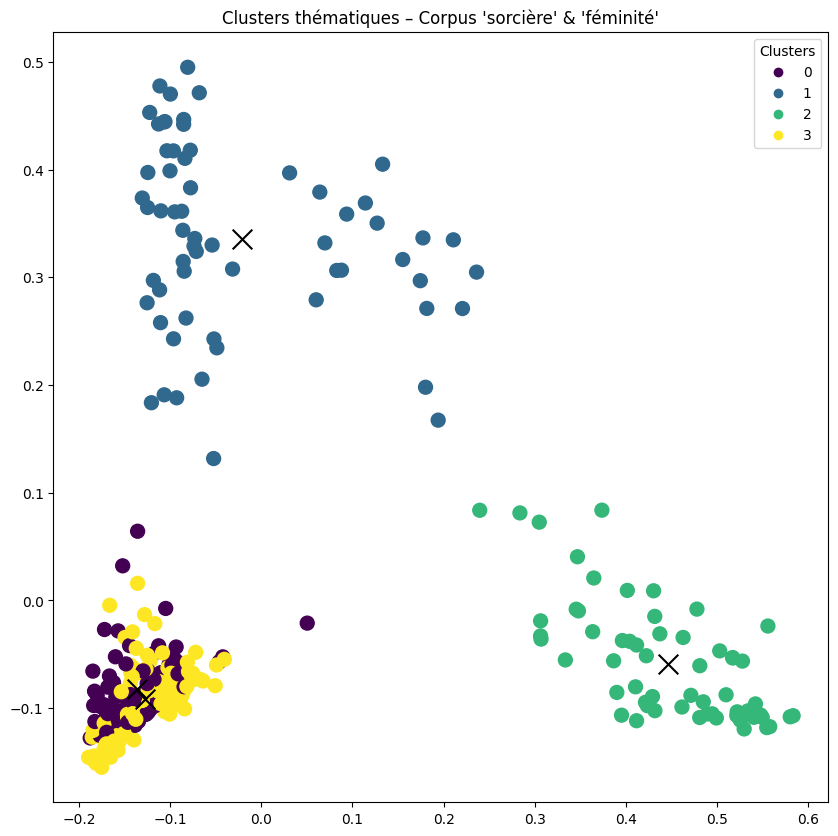

In [74]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_array)

x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# centroides
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:,0], centroids[:,1], marker="x", s=200, color="black")

plt.title("Clusters thématiques – Corpus 'sorcière' & 'féminité'")
plt.legend(handles=scatter.legend_elements()[0],
           labels=set(clusters),
           title="Clusters")
plt.show()
